#### Github:
https://github.com/hibbakamas/ML-fundamentals-2025.git

# Hibba Kamas Machine Learning Assignment 2

In [400]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Task 1: Exploratory Data Analysis (EDA)

In [401]:
# Load dataset
df = pd.read_csv("hour.csv")

# Show first few rows
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Checking Dataset Structure

Before starting to create the model, it's important to understand the structure and contents of the dataset. I began by checking the shape of the dataset and listing the column names. This gives a quick overview of how many observations we have (17,379 rows) and how many features (17 columns), helping us understand the dataset better before continuing.

In [402]:
# basic info about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns)

Dataset Shape: (17379, 17)

Column Names:
 Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


#### Identifying Missing Values

Missing data can affect the model's accuracy, so it is very important to assess which features have missing values. Luckily in this case, there are no missing values

In [403]:
# Check number of missing values per column (if any)
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### Summary Statistics Observations

After gaining a general overview of the dataset, .describe() and .info() are used to view summary statistics about the dataset. Some key observations include:

- All 17 columns contain 17,379 non-null entries, which confirms there are no missing values.
- Most features are numerical, with only one object column ("dteday").
- The target variable "cnt" (total bike rentals) ranges from 1 to 977, with a mean around 189. This wide range suggests a right-skewed distribution, which may affect linear modeling.
- "temp", "atemp", "hum", and "windspeed" are normalized between 0 and 1.
- Binary features like "holiday" and "workingday" have values of 0 or 1.
- Columns like "season", "hr", "weekday", and "weathersit" are encoded as categorical integers, which we should keep in mind when making the different models.
- The "instant" column is a unique identifier and does not carry predictive value, so it will be dropped.
- The "dteday" column represents the date as a string and does not add predictive value either, so it will also be dropped.

In [404]:
# Check the structure and types of the dataset
df.info()
# Get basic statistics for numerical columns
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### Distributions and outliers

After observing that our target variable could possibly be right-skewed, I decided to investigate further by using a histogram. The histogram confirmed that cnt is indeed right skewed, with most rental counts being quite low and then a sharp drop as the count increases.

Skewness is very important to keep in mind, especially for linear regression, which assumes the target and residuals are normally distributed. To address this, we could apply a log transformation to the target variable, to better meet the assumption of normality and linearity. 

Although decision trees and random forests are more robust to skewed data since they do not assume any underlying distribution, understanding the distribution of the target variable may help with tuning and identifying outliers and imbalances.

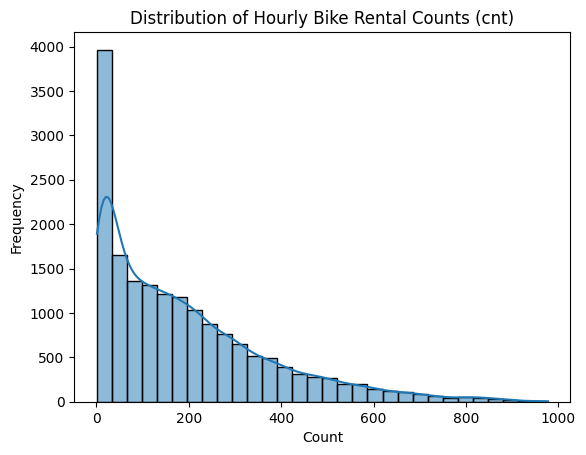

In [405]:
# Histogram of the target variable
sns.histplot(df['cnt'], bins=30, kde=True)
plt.title("Distribution of Hourly Bike Rental Counts (cnt)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()


Since extreme values in numerical features can mess up the model's predictions, I decided to do a formal outlier check the target variable. Outliers can affect model's in different ways:
- In linear regression, outliers can heavily influence the fitted line which may skew results. Outlier handling methods or transformations may be necessary.
- Decision trees and random forests are more robust to outliers due to their non-linear nature. Extreme values tend to be in separate branches, minimizing their impact.

In the boxplot, we can see a large number of outliers on the higher end, more specifically beyond 600. These high values are not necessarily errors, they might just be busier times, such as rush hour. Hence, it is not for sure that they will be removed, but I can now make more informed decisions about whether to:
- Apply a log transformation in linear regression
- Leave them untouched for tree based models
- Investigate them further depending on model performance

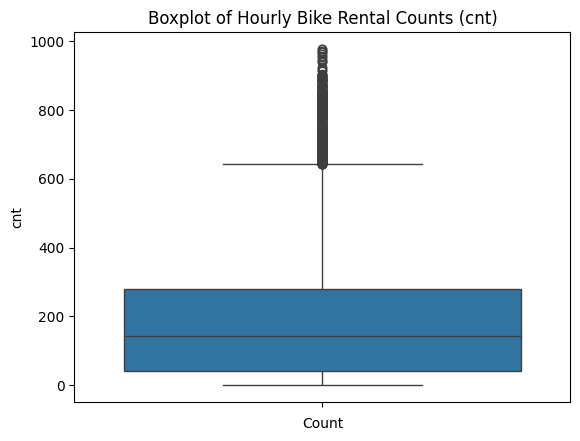

In [406]:
# Boxplot to check for outliers
sns.boxplot(y=df['cnt'])
plt.title("Boxplot of Hourly Bike Rental Counts (cnt)")
plt.xlabel("Count")
plt.show()


To better understand the behavior of the numerical input features, I visualized their distributions and boxplots. This helped identify skewness, outliers, and patterns that might impact the model.

Instead of automatically selecting numerical features using select_dtypes(), I manually selected them based on dataset knowledge. I preferred this method because sometimes, some columns are classified as numerical due to their integer values, but are actually categorical (season, yr, mnth, etc).

Some key observations include:
- Distributions:
    - temp, atemp, and hum are rougly symmetric and are fairly well distributed.
    - windspeed, casual, and registers are right skewed, with many low values and few high values. These features might need transformation, depending on the model.
    - temp and atemp look very similar, implying one might be redundant. A correlation check should be done.
    - casual and registered also seem very similar to each other, as well as to cnt. Based on dataset knowledge, I figure that cnt is the sum of casual and registered. It is important to verify this later, as if this is true it will lead to data leakage.
- Outliers:
    - Boxplots showed outliers in windspeed, casual, and registered.
    - These values are not necessarily errors, and may represent real-world scenarios such as a windy day
    - In linear regression, these outliers may mess up predictions and might require transformation, however in tree based models outliers are isolated and have less impact.

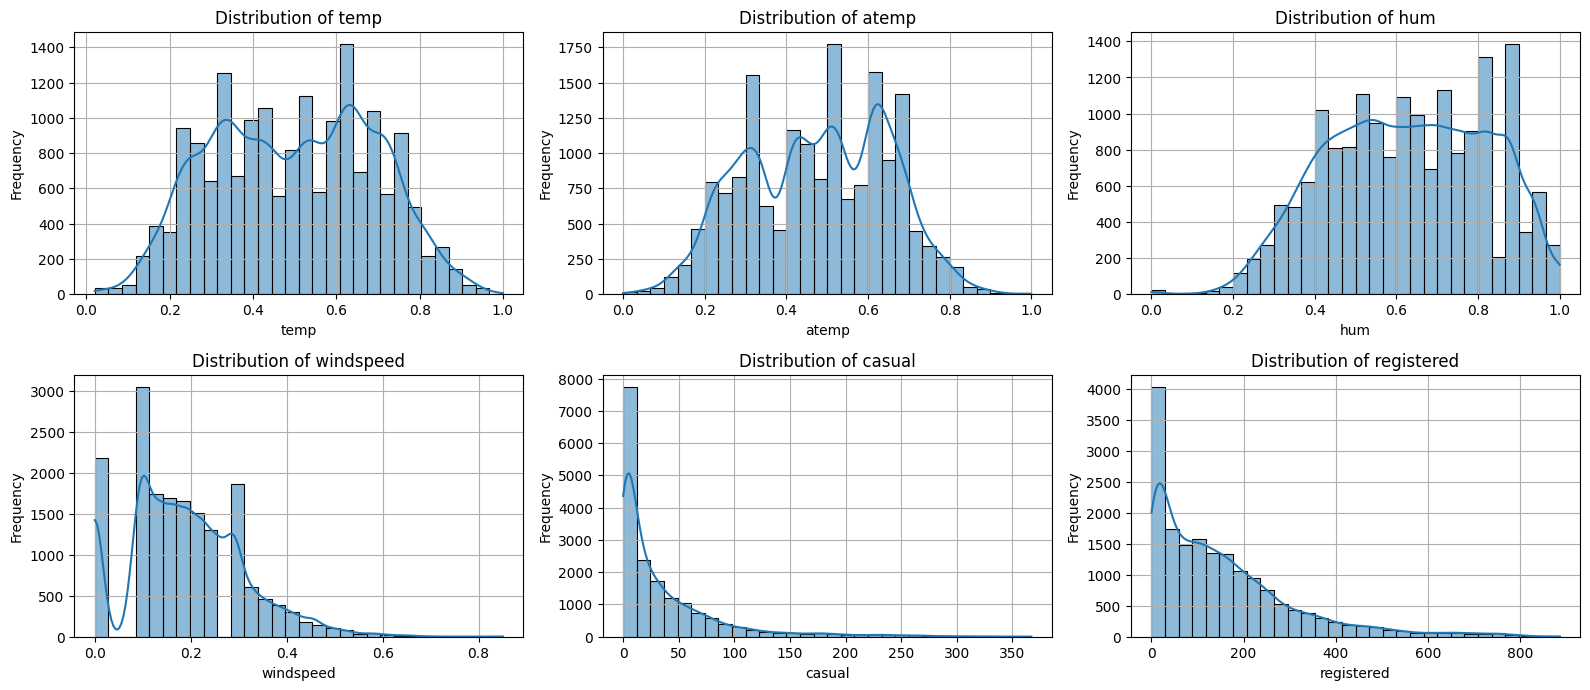

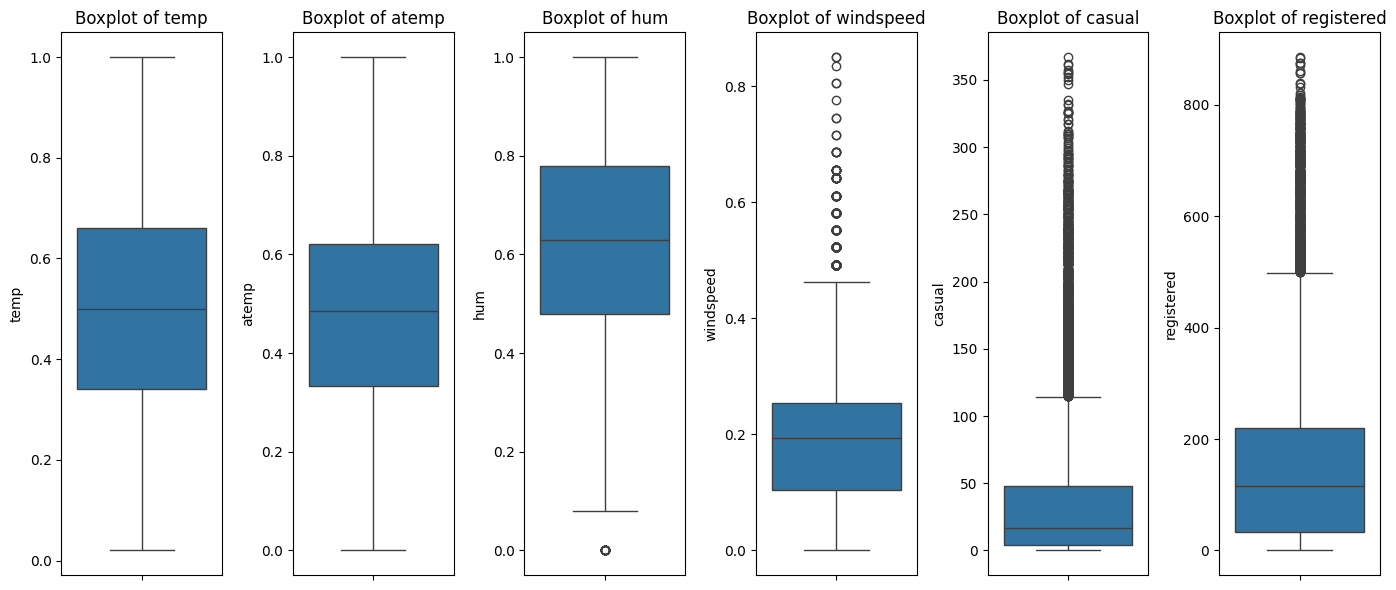

In [407]:
numerical_features = ["temp", "atemp", "hum", "windspeed", "casual", "registered"]

# distributions
plt.figure(figsize=(16, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(True)
plt.tight_layout()
plt.show()

# boxplots
plt.figure(figsize=(14, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 6, i)
    sns.boxplot(y=df[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

Since earlier I thought that cnt could be the sum of casual and registered, I decided to confirm this with a scatter plot of casual + registered against cnt. This result showed a perfect linear relationship. To be extra thorough, I also ran a check to see if there were any mismatches between casual + registered and cnt. The mismatch count was 0, finally confirming what I originally thought.

This is a very important find, as including both features when predicting cnt would lead to data leakage, since they directly determine the target. These two columns should be dropped before modeling to ensure the model does not 'cheat'.

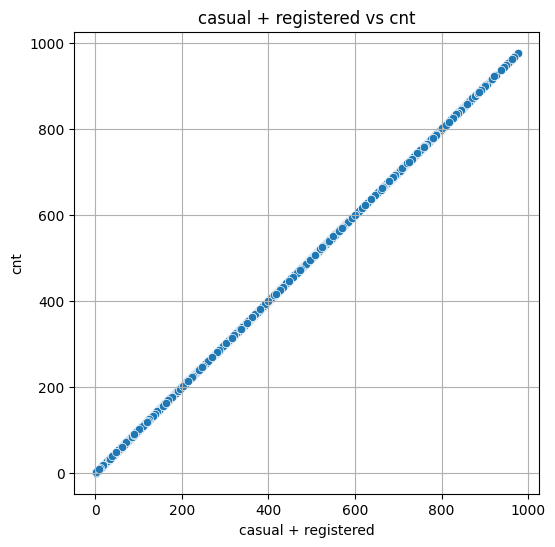

Number of mismatches: 0


In [408]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df['casual'] + df['registered'], y=df['cnt'])
plt.title("casual + registered vs cnt")
plt.xlabel("casual + registered")
plt.ylabel("cnt")
plt.grid(True)
plt.show()

# Check if any rows break the rule: casual + registered == cnt
mismatch_count = (df['casual'] + df['registered'] != df['cnt']).sum()
print("Number of mismatches:", mismatch_count)

### Influence of temporal features
For temporal features like hr, weekday, and mnth, Line plots were used to visualize the average rental trends. Line plots work very well for ordered, time based variables because they highlight changes/patterns across a continuous timeline very clearly.


Hour:

First, I thought to explore the influence of time on bike usage. I began by checking the average number of rentals for each hour of the day, since different hours of the day (eg, rush hour) may behave differently.

From the line plot, I observed:
- From the hours of 12:00am to 6:00am, usage is at it's lowest. This makes sense considering most people are likely asleep and not commuting at this time.
- There is a sharp increase from 6:00am to 8:00am, which corresponds to common morning commute times. This suggests many people rely on bikes to get to work or school.
- From 9:00am to 4:00pm rentals decrease and remain relatively steady, but between 4:00pm and 7:00pm rentals go back up, corresponding to the time people commute home from work or school.

This hourly pattern is clearly non linear, meaning:
- Tree based models (decision trees, random forests) are well suited since they are flexible to non linearity.
- Linear models may struggle unless we apply transformations.

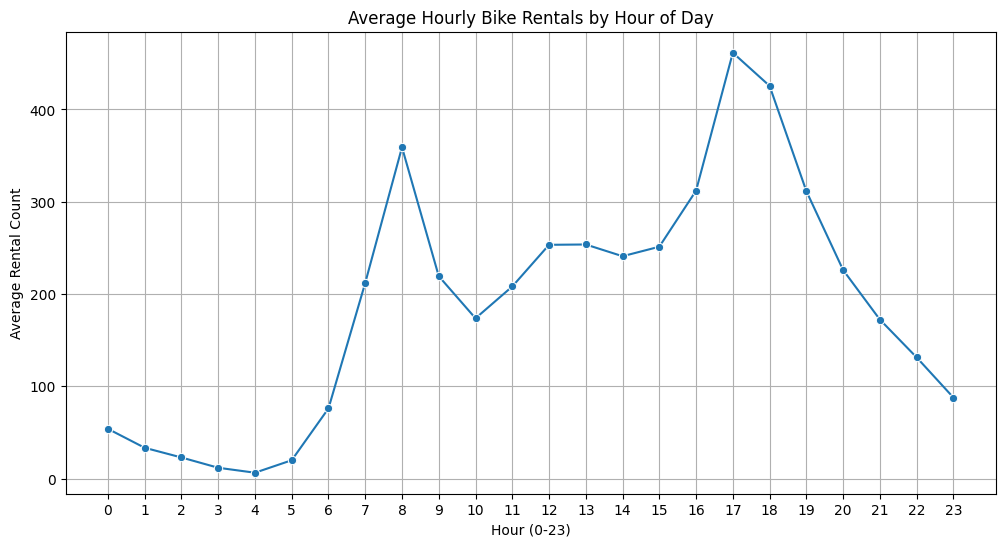

In [409]:
# Average bike rentals by hour of the day
avg_by_hour = df.groupby("hr")["cnt"].mean()

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_by_hour.index, y=avg_by_hour.values, marker="o")
plt.title("Average Hourly Bike Rentals by Hour of Day")
plt.xlabel("Hour (0-23)")
plt.ylabel("Average Rental Count")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

Weekday:

Next, I checked how different days of the week affect bike rentals, gaining a more general influence of time's influence. I plotted the average rental count per day using a line plot, since weekdays follow a natural timeline.

From the plot, I observed:
- Rentals are lowest on Sunday, then begin to increase during the week. This might suggest people stay home more often on Sundays.
- The highest usage is on Thursday and Friday, which may be due to a combination of work, errands, and social plans.
- Rentals drop slightly on Saturday, probably because people are not commuting to work/school.

Although there aren't huge differences, the pattern suggests that weekday does indeed have some influence on rentals. Its ordered nature may benefit tree-based models, however linear models might require  encoding to properly interpret it. In this case, one hot encoding may be more appropriate than ordinal encoding even though weekday is ordered, because its relationship with the target is not linear.

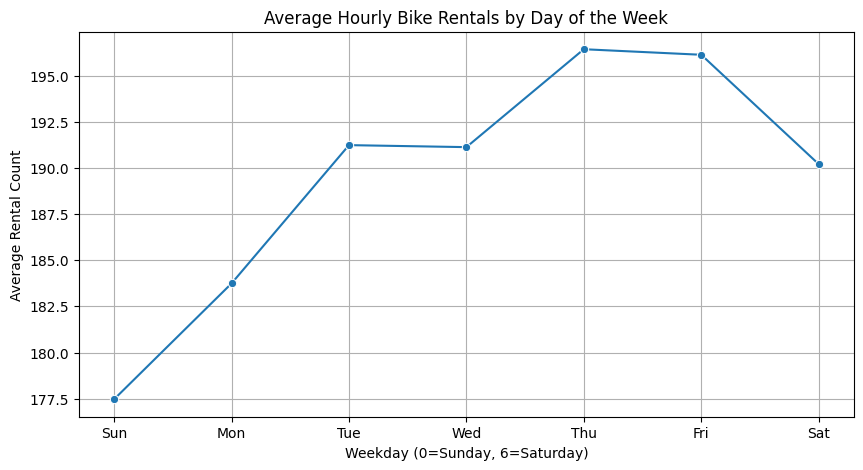

In [410]:
# Average rentals by weekday (0=Sunday, 6=Saturday)
avg_by_weekday = df.groupby("weekday")["cnt"].mean()

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_by_weekday.index, y=avg_by_weekday.values, marker="o")
plt.title("Average Hourly Bike Rentals by Day of the Week")
plt.xlabel("Weekday (0=Sunday, 6=Saturday)")
plt.ylabel("Average Rental Count")
plt.xticks(range(0, 7), labels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.grid(True)
plt.show()


Month:

I then visualized the influence of the month of bike rentals, gaining an even more general overview of the influence of time.

From the plot, I observed:
- Rentals continuously increase from January to June (peak), and stay high during the warmer months (June to September).
- After September, rentals begin to drop, with the lowest rentals in the coldest months (December to Febuary).
- This pattern seems to reflect seasonal weather effects, suggesting that people prefer to ride bikes in warmer, drier months,

Again, this trend is clearly non-linear, hence although tree based models do not require transformations, linear models would.

Here, the relationship between month and cnt seems to follow a clear downward u shape. Creating a variable mnth^2 might help linear regression models capture this relationship better and won't have negative effects on decision tree or gradient boosting models.

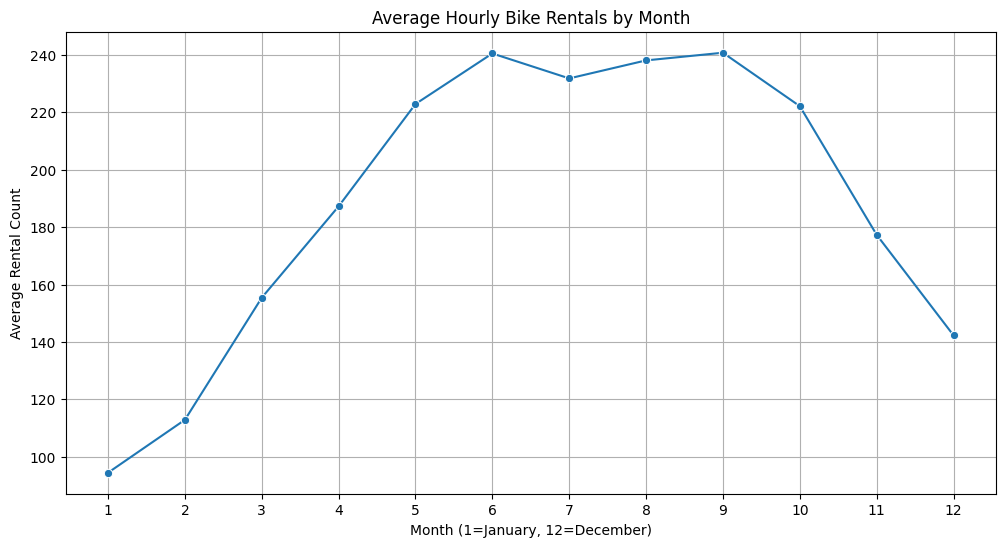

In [411]:
# Average rentals by month
avg_by_month = df.groupby("mnth")["cnt"].mean()

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_by_month.index, y=avg_by_month.values, marker="o")
plt.title("Average Hourly Bike Rentals by Month")
plt.xlabel("Month (1=January, 12=December)")
plt.ylabel("Average Rental Count")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

Season:

Finally, since the hourly bike rentals by month seemed to vary depending on the season, I visualized the average rental count using a bar plot.

From the plot, I observed:
- Rentals are lowest in Winter, implying people do not like to ride bikes in the cold.
- Rentals increase in Spring and Summer, with Summer having the highest average. This suggests warm weather encourages biking.
- In fall, rentals slightly drop, but are still relatively high.

These are the same interpretations inferred from analyzing the months of the year, implying the rental count changes in the months might be due to seasonal changes.

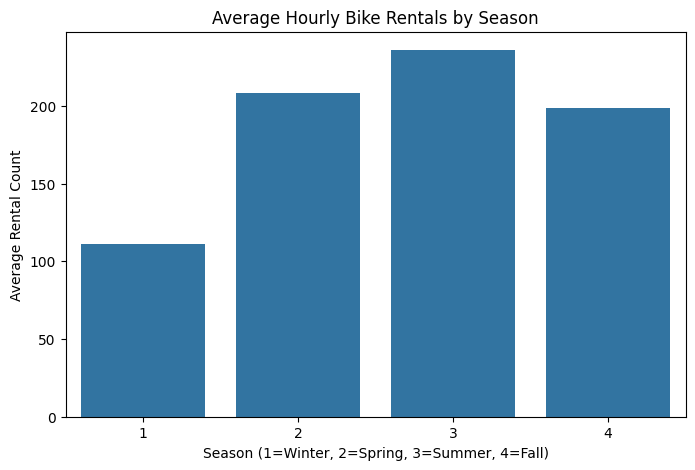

In [412]:
avg_by_season = df.groupby("season")["cnt"].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_by_season.index, y=avg_by_season.values)
plt.title("Average Hourly Bike Rentals by Season")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("Average Rental Count")
plt.show()

### Influence of binary features
Since these features only take two values (0 and 1), bar plots are the most intuitive and effective way to compare their impact on the target variable.

Holiday:

To check whether holidays influence bike rentals, I plotted the average rental count grouped by holiday.

From the plot, I observed:
- Rentals are higher on non holidays compared to holidays.
- The reason for this might be because people normally commute to work/school on non holidays using bikes.

Although the difference is not huge, this shows holiday does have some influence on the target variable and implies it should be kept.

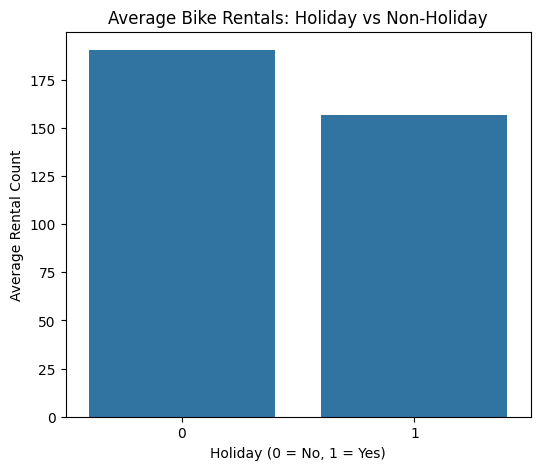

In [413]:
# Average rentals grouped by holiday
avg_by_holiday = df.groupby("holiday")["cnt"].mean()

# Bar plot
plt.figure(figsize=(6, 5))
sns.barplot(x=avg_by_holiday.index, y=avg_by_holiday.values)
plt.title("Average Bike Rentals: Holiday vs Non-Holiday")
plt.xlabel("Holiday (0 = No, 1 = Yes)")
plt.ylabel("Average Rental Count")
plt.show()

Working day:

To see how working days might affect bike rentals, I used a bar plot to compare average rental counts between working and non working days.

From the plot, I observed:
- Rentals are just slightly higher on working days.
- This makes sense and aligns with everything said previously, people rely on bikes as part of their commute to work/school.

The difference is only small, but still shows some relationship with the target variable.

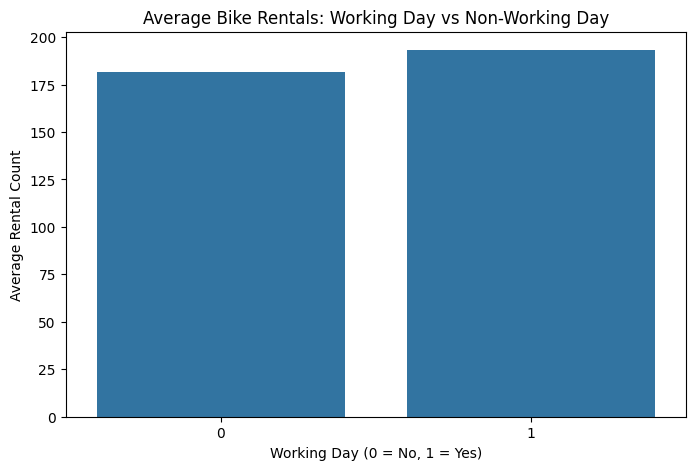

In [414]:
# Average rentals by working day
avg_by_workingday = df.groupby("workingday")["cnt"].mean()

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_by_workingday.index, y=avg_by_workingday.values)
plt.title("Average Bike Rentals: Working Day vs Non-Working Day")
plt.xlabel("Working Day (0 = No, 1 = Yes)")
plt.ylabel("Average Rental Count")
plt.show()

### Influence of weather related features

Line plots were used for continuous features (temp, atemp, hum, and windspeed) and bar plots for categorical ones (weathersit).

Temp:

I first felt it was important to understand how temperature influences bike usage, since it seemed to have a large impact in earlier analysis. So, I plotted the average rental count for each unique normalized temperature value using a line plot.

From the plot, I observed:
- Rentals tend to increase with temperate, which confirms our earlier hypothesis that people prefer renting bikes in warmer weather.
- The trend becomes less consistent at higher temperatures, possibly due to fewer data points at those extremes.

This relationship is more or less linear, and can be handled well with linear models and tree based models.

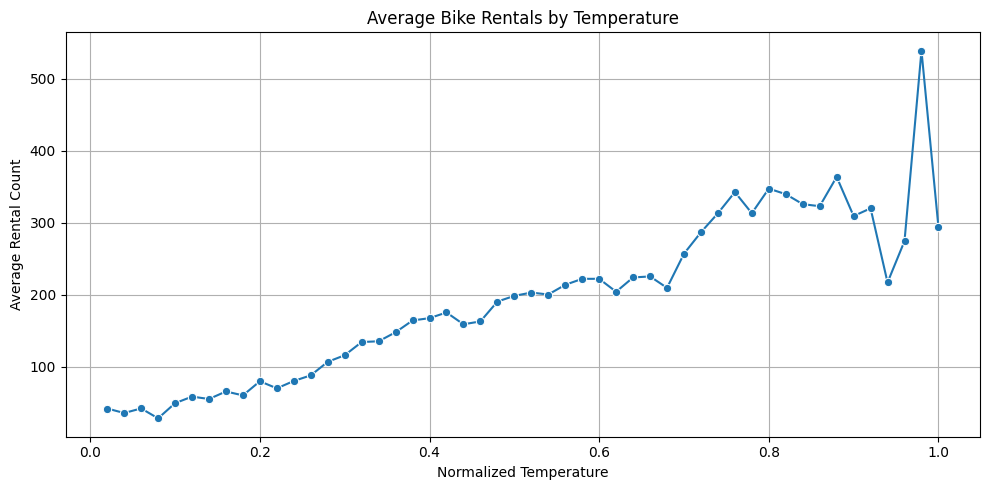

In [415]:
# Average rentals by temperature
avg_temp = df.groupby("temp")["cnt"].mean().reset_index()

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x="temp", y="cnt", data=avg_temp, marker="o")
plt.title("Average Bike Rentals by Temperature")
plt.xlabel("Normalized Temperature")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Atemp:

I also checked how the "feels like" temperature influences bike usage, since this might have more of an impact on people if it is the temperature they actually feel.

From the plot, I observed:
- Rentals increase as "feels like" temperature increases.
- The pattern is very similar to temp, implying some correlation that should be checked.

Again, the pattern is more or less linear, with the behavior closely mirroring temp. This supports the earlier assumption that one of these features might be redundant.

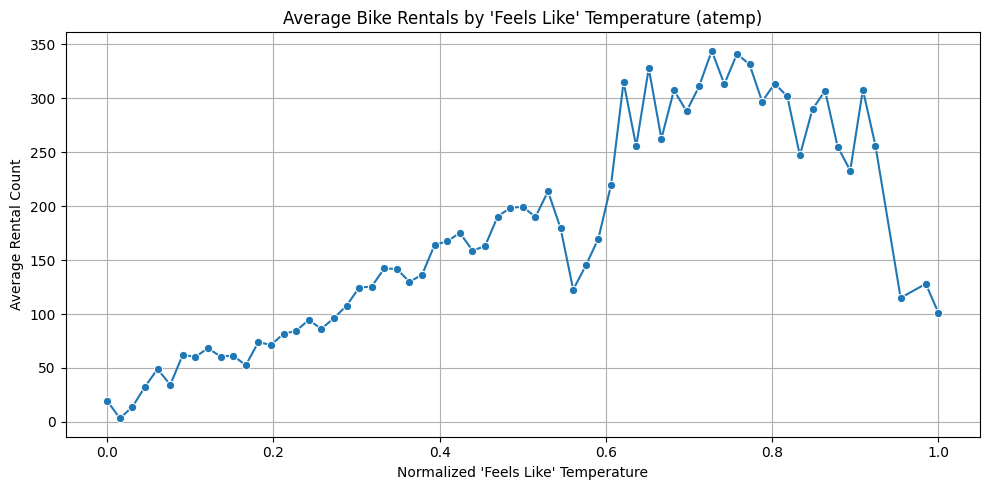

In [416]:
# Average rentals by atemp
avg_atemp = df.groupby("atemp")["cnt"].mean().reset_index()

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x="atemp", y="cnt", data=avg_atemp, marker="o")
plt.title("Average Bike Rentals by 'Feels Like' Temperature (atemp)")
plt.xlabel("Normalized 'Feels Like' Temperature")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Humidity:

Next, I analyzed how humidity might affect bike rentals rates, as humid weather tends to be less enjoyable. I used a line plot to capture this relationship.

From the plot, I observed:
- Rentals increase as humidity rises from 0 to 0.2, suggesting people do not prefer overly dry weather to ride their bikes.
- After this, rental counts decline as humidity increases, confirming my earlier assumption.

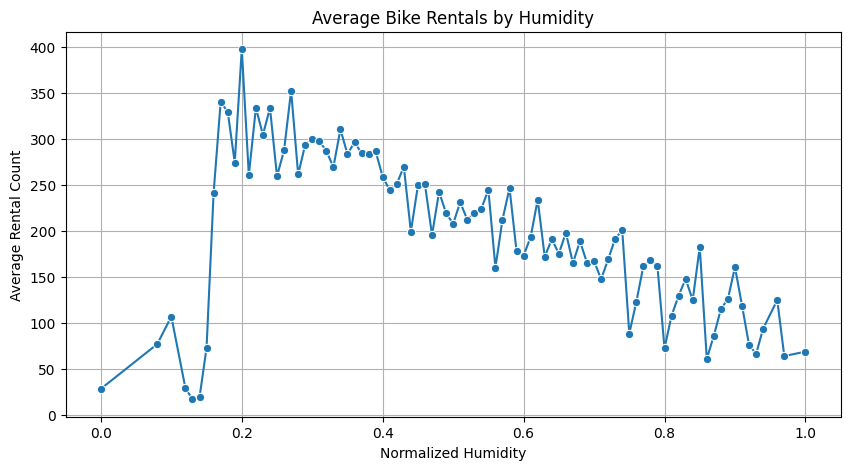

In [417]:
# Average rentals by humidity
avg_by_hum = df.groupby("hum")["cnt"].mean()

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_by_hum.index, y=avg_by_hum.values, marker="o")
plt.title("Average Bike Rentals by Humidity")
plt.xlabel("Normalized Humidity")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.show()

Windspeed:

I then explored how windspeed would affect bike rentals using a lineplot, as windier weather is not ideal for riding a bike.

From the plot, I observed:
- Rental counts are pretty stable across low to moderate windspeeds.
- At higher windspeeds (beyond 0.6) rental counts begin to drop, though it is difficult to tell probably due to fewer data points.

The overall influence of windspeed is very mild, but it may have a slight negative effect on rentals at higher windspeeds.

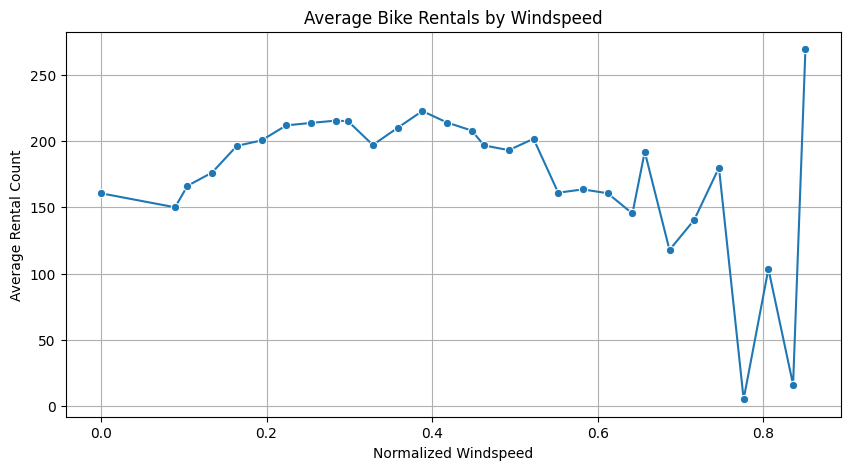

In [418]:
# Calculate average rental count by windspeed
avg_by_windspeed = df.groupby("windspeed")["cnt"].mean()

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_by_windspeed.index, y=avg_by_windspeed.values, marker="o")
plt.title("Average Bike Rentals by Windspeed")
plt.xlabel("Normalized Windspeed")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.show()

Weathersit:

I finally explored how different weather conditions may influence bike rentals, excluding category 4 due to its extremely low frequency which will just add noise.

From the plot, I observed:
- Rentals are highest on clear or partly cloudy days, which makes sense as the weather is ideal for biking.
- Rentals decrease on misty or cloudy days, possibly because of reduced visibility.
- Rentals experience a sharp drop when it rains or snows lightly, suggesting that bad weather discourages biking.

This analysis showed that weathersit clearly influences rental behavior, and should be kept as a feature in the model.

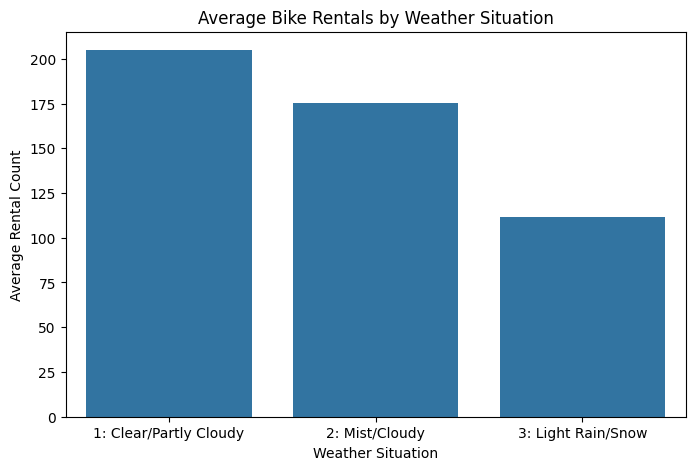

In [419]:
# Filter out rows where weathersit is 4
df_filtered = df[df["weathersit"] != 4]

# Define custom labels for valid categories
weather_labels = [
    "1: Clear/Partly Cloudy",
    "2: Mist/Cloudy",
    "3: Light Rain/Snow"
]

# Group by weather situation and calculate average rentals
avg_by_weather = df_filtered.groupby("weathersit")["cnt"].mean()

# Create bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_by_weather.index, y=avg_by_weather.values)
plt.title("Average Bike Rentals by Weather Situation")
plt.xlabel("Weather Situation")
plt.ylabel("Average Rental Count")
plt.xticks(ticks=[0, 1, 2], labels=weather_labels)
plt.show()

### Possible interaction terms

Temperature x humidity:

I tested this interaction because logically, humidity might affect how temperature affects bike rentals. I would assume for example that the combination of high heat and high humidity would make people less likely to ride bikes in comparison to high heat with low humidity.

To test this, I used a grouped lineplot to check for the interaction visually. Grouped by different levels of humidity, the slopes of temperature vs count seemed to differ depending on the humidity level. If this is true, this would mean that temp and hum do indeed have an interaction.

I decided to properly check for the slopes, since the graph was not 100% clear. The slopes were calculated as 447.72 for low humidity, and only 196.54 for high humidity. This large gap in slopes confirms an interaction effect that should be tested, feature 'temp_hum' may be created.

<Axes: xlabel='temp', ylabel='cnt'>

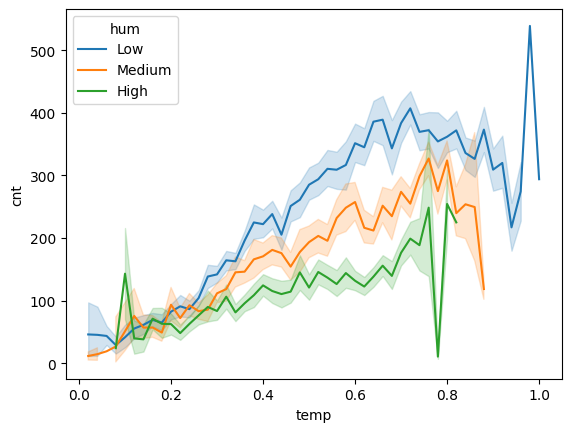

In [420]:
sns.lineplot(
    data=df,
    x='temp',
    y='cnt',
    hue=pd.qcut(df['hum'], q=3, labels=['Low', 'Medium', 'High'])
)


In [421]:
# Calculate slope for each humidity group without creating new columns
slopes = {}
hum_groups = pd.qcut(df['hum'], q=3, labels=['Low', 'Medium', 'High'])

for group in ['Low', 'Medium', 'High']:
    # Filter the data without creating a new column
    mask = hum_groups == group
    group_temp = df.loc[mask, 'temp']
    group_cnt = df.loc[mask, 'cnt']
    
    # Calculate slope for this group
    slope, intercept = np.polyfit(group_temp, group_cnt, 1)
    slopes[group] = slope

print("Slopes (temp vs cnt) for each humidity group:")
for group, slope in slopes.items():
    print(f"{group} humidity: {slope:.4f}")

Slopes (temp vs cnt) for each humidity group:
Low humidity: 447.7213
Medium humidity: 379.6576
High humidity: 196.5361


The next interaction I tested was whether the effect of the hour of the day on bike rentals were different on working days vs non working days. This would make sense, as rush hour for example is much more likely on working days.

I used a grouped lineplot of rental count by hour, split by whether it was a working day or not. The plot showed two completely different patterns. On working days, there was a double peak (8am and 5pm), aligning with commuting hours. On on working days, the pattern is much smoother with one rise at around midday, and no peaks.

These major differences show that the relationship between hour and rentals differs a lot across working/non-working days. This confirms a strong interaction. A new feature 'hour_workingday' may be created.

<Axes: xlabel='hr', ylabel='cnt'>

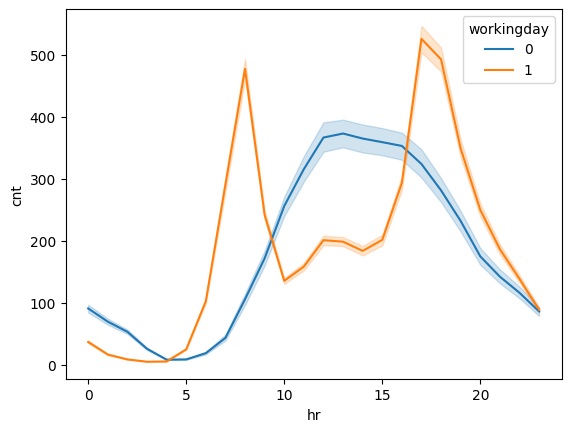

In [422]:
sns.lineplot(data=df, x='hr', y='cnt', hue='workingday')

This interaction was checked since I thought the effect of the time of the day might change depending on the temperature (for example, people may ride bikes less midday if it is very hot).

To test this, I created a grouped lineplot of rental count by hour, split by different temp levels. There were only small differences, and the shape of the hourly pattern did not change. From the graph, it seems the only change due to temperature was a shift.

I concluded there was no real interaction between temperature and hour

<Axes: xlabel='hr', ylabel='cnt'>

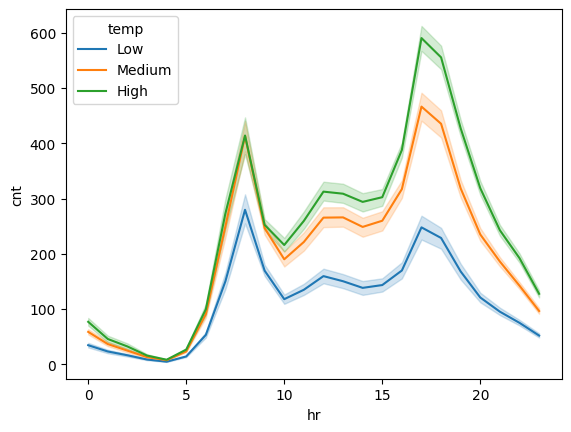

In [423]:
sns.lineplot(
    data=df,
    x='hr',
    y='cnt',
    hue=pd.qcut(df['temp'], q=3, labels=['Low', 'Medium', 'High'])
)

### Correlation heatmap

Finally, the last EDA step I thought to perform was correlation analysis between the numerical features. Correlation analysis can help identify relationships and provide insights about how they interact. It can also provide important insights when it comes to feature selection, as if two features are highly correlated, one might be redundant and we can remove it and effectively reduce dimensionality. This will be very useful later, during feature selection. 

From the heatmap, I observed:

- temp and atemp have an extremely high correlation of 0.99, confirming the earlier suspicion that one is redundant.

- casual and registered are moderately correlated (0.51), and both are positively correlated with temp and atemp.

- windspeed has very low correlation with all other features, indicating it is fairly independent.

This correlation analysis supports dropping atemp due to redundancy with temp, and confirms the importance of removing casual and registered to avoid data leakage (since we earlier confirmed cnt = casual + registered).

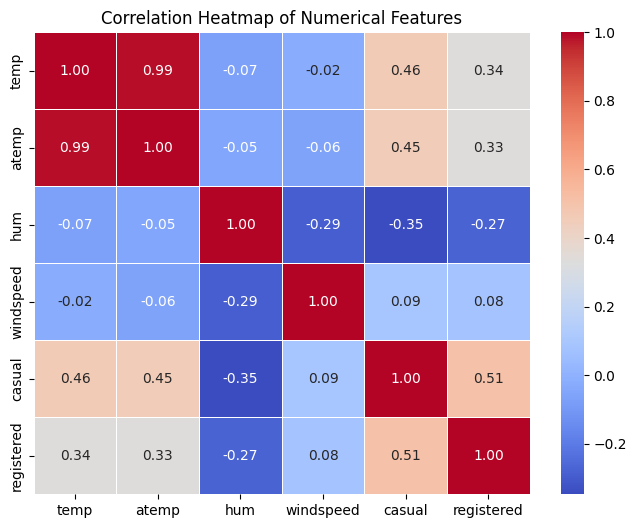

In [424]:
numerical_features = ["temp", "atemp", "hum", "windspeed", "casual", "registered"]

plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### EDA Summary
Throughout the EDA process, I made decisions with all three models in mind (linear regression, decision tree, and random forest) as each has different sensitivities and strengths: 


Linear Regression:
- Skewness and outliers in the target variable and features were checked early, since linear models are sensitive to this.

-  I checked which relationships are linear vs non linear, and noted where transformations may be necessary.

- Dropping atemp (due to high correlation with temp) helps prevent multicollinearity.

- One-hot encoding was identified as the best strategy for categorical features like weekday and season, since linear models can't handle non-numeric or ordinal features effectively.

- Interaction terms were identified, which is especially important for linear regression, which cannot model interactions without explicit feature engineering.

Decision Tree:
- Trees handle non-linearity and outliers well, so I focused on identifying strong splits (e.g., sharp peaks in hr, drops in weathersit).

- No transformations are required (features like hr, temp, and hum can be used directly).

- Categorical features like season and weekday can be kept as integers because decision trees treat them as discrete values without assuming order.

Random Forest:
- Similar to decision trees, Random Forest benefits from clean, non-redundant features.

- Dropping atemp reduces noise and unnecessary complexity.

I also ensured no data leakage by dropping casual and registered, which would have otherwise led to artificially high accuracy.

Although scaling isn’t required, the removal of irrelevant or sparse features (like instant, dteday, and rare weathersit=4) helps avoid overfitting and improves generalization.

# Task 2: Data Splitting

Before performing any feature engineering or scaling, I split the dataset into training (60%), validation (20%), and test sets (20%). This is done early on, as if we scale features before splitting, the mean and standard deviation would be computed from the entire dataset, which means that test data would influence how the training data is transformed, leading to data leakage. The choice of 60 20 20 is based on the fact our dataset is relatively large, hence we can spare some data for validation and testing. This may be reconsidered during hyperparameter tuning.

To avoid leakage and preserve the natural timeline of the data, I began by sorting the data by the date and hour, although it might have already been sorted, as an extra precaution. I did not shuffle the data and use the regular train_test_split function, as this would randomly split the dataset, and maintaining temporal order is crucial when it comes to time sensitive data. Then, I calculated the index positions of the training and validation sets and used array slicing to split the dataset into three sequential parts. After a quick verification of the split sizes, I separated the features (X) and the target variable cnt (Y) for each set.

This way, we ensure a realistic model that mimics real-world scenarios and data leakage is avoided by ensuring the model is trained on earlier data and evaluated on future data.

Although tools like TimeSeriesSplit (skikit-learn) and temporal_train_test_split (sktime) exist for splitting time based data, I chose not to use them for this task for the following reasons:
1. TimeSeriesSplit is designed for time series cross validation, and hence creates folds rather than fixed 60/20/20 splits. To control exact percentages, it would need additional customization and unnecessary complexity.
2. temporal_train_test_split is designed for time series forecasting problems. However, our dataset is tabular data with a time component, and the goal is not to forecase future time steps.

In the end, I decided my manual approach was more appropriate, simpler, and still preserves the timeline of the data.

In [425]:
# Sort by date and time if not already sorted
df = df.sort_values(by=['dteday', 'hr'])

# Calculate split indices
n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

# Split the data
train_df = df[:train_end]
val_df = df[train_end:val_end]
test_df = df[val_end:]

# Verify the split sizes
print(f"Training set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# Separate features and target
X_train = train_df.drop('cnt', axis=1)
y_train = train_df['cnt']

X_val = val_df.drop('cnt', axis=1)
y_val = val_df['cnt']

X_test = test_df.drop('cnt', axis=1)
y_test = test_df['cnt']

Training set size: 10427 (60.0%)
Validation set size: 3476 (20.0%)
Test set size: 3476 (20.0%)


# Task 3: Feature Engineering

### Initial data cleaning

The first step I did was to remove obvious redundancies and issues found in EDA, before employing more technical processing steps. These features were dropped to ensure a clean dataset:

- atemp: Has a 0.99 correlation with temp, making it redundant for model training.
- instant: An ID column, does not provide any useful information for prediction.
- dteday: Date, does not provide any useful information for prediction.
- casual and registered: Components of the target variable cnt (cnt = casual + registered). Keeping them would lead to data leakage, so they were dropped early on.


In [426]:
# Drop obvious redundancies and leakage-prone columns identified in EDA
cols_to_drop = ['atemp', 'instant', 'dteday', 'casual', 'registered']

for X in [X_train, X_val, X_test]:
    X.drop(columns=cols_to_drop, inplace=True)

### Creating New Features


Next, I created features based on relationships identified during EDA.

- temp_hum: This interaction term was added after observing that the effect of temp on bike rentals varied depending on humidity. A grouped lineplot showed that rentals increase more steeply with temperature under low humidity than high humidity.

- hour_workingday: This interaction term captures the difference in hourly rentals between working and non working days. On working days, there is a sharp double peak during commute hours, while on non working days, rentals steadily rise toward the afternoon. This massive change in the shape of the pattern confirmed a strong interaction between hr and workingday.

- mnth_squared: The rental pattern across months followed an upside down u shape. To allow the linear regression model to capture this non linearity, a squared version of mnth was added. Now, the linear model can fit the curve, while tree-based models will simply use the variable as it is or ignore it if unhelpful.

No additional plots were created here since decisions were already thoroughly explained and justified during EDA through plots. This step focused purely on implementation of features already identified as potentially valuable.


In [427]:
for X in [X_train, X_val, X_test]:
    X['temp_hum'] = X['temp'] * X['hum']
    X['hour_workingday'] = X['hr'] * X['workingday']
    X['mnth_squared'] = X['mnth'] ** 2

### Encoding Cyclical Features & Categorical Variables

Originally, I tried to find the categorical variables using code, by selecting all the object type columns. However, that led to incorrect results, so I manually selected season and weathersit as categorical features instead. Features hr, weekday, and mnth were selected as cyclical features. Although in the assignment, mnth was classified as a categorical variable rather than a cyclic variable, it is truly cyclical in nature hence I grouped it with hr and weekday.

Encoding may be done before or after splitting, but I decided to encode after splitting mainly to avoid data leakage. If we encode then split, info from the test/validation sets would influence training, and then the model would indirectly learn from data it was not supposed to see.

If encoding is done before splitting, we would avoid a common issue: a category that was not in the training set appears in the validation/test sets, causing an error. However there is a way to handle this, which is setting the parameter handle_unknown = "ignore"

To keep the cyclical nature of time related features, I used sine and cosine transformations. These transformations convert the original feature into two new features: sin(feature) and cos(feature), which perserve the periodic patterns of these features. Sin and cos functions are periodic, meaning they tend to repeat their values over a certain interval. Hence, they are the perfect choice for representing cyclical data. They also help avoid discontinuities (for ex, jumpting from december (12) to january (1)).

I considered normalizing the variables first, however as long as I ensured to scale the original feature to the appropriate range (dividing by the cycle length) before applying sin/cos, the transformation itself handles the normalization.

In [428]:
for X in [X_train, X_val, X_test]:
    # Hour: range 0–23
    X['hr_sin'] = np.sin(2 * np.pi * X['hr'] / 24)
    X['hr_cos'] = np.cos(2 * np.pi * X['hr'] / 24)

    # Weekday: range 0–6
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Month: range 1–12
    X['mnth_sin'] = np.sin(2 * np.pi * X['mnth'] / 12)
    X['mnth_cos'] = np.cos(2 * np.pi * X['mnth'] / 12)

Features season and weathersit were simply one hot encoded, since there exists no order or hierarchy.

To prevent errors in the case that there is a category in the test/validation sets that was not in the training set, the parameter handle_unknown is set to ignore. This ensures that unseen categories in the test set do not cause errors, as they will be ignored. The parameter sparse_output is set to false to return a dataframe rather than a sparse matrix. I set drop= "first" to avoid multicollinearity, which happens when all categories are included as separate columns. By dropping one category, the categories left are compared to the dropped one which becomes a baseline or reference, preventing redundant information in the model.

In [429]:
# Define encoder
onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")

Then, the encoder is fit only on the training data (to avoid data leakage), and we use the same transformation on the test and validation sets. 

In [430]:
# Fit on training set
X_train_encoded = onehot_encoder.fit_transform(X_train[["season", "weathersit"]])
# Transform val and test sets (DO NOT fit again!)
X_val_encoded = onehot_encoder.transform(X_val[["season", "weathersit"]])
X_test_encoded = onehot_encoder.transform(X_test[["season", "weathersit"]])


The next step is to merge the newly encoded data with the old dataset, however OneHotEncoder outputs a NumPy array instead of a dataframe, which is needed to merge with the original dataset. So, we must assign meaningful names to the new columns. At first I thought to manually rename the columns, however this turned out to be tedious and led to unnecessary errors. Upon further research, I decided to use get_feature_names_out, which automatically generates meaningful column names.

The encoded data is now converted into a dataframe with the appropriate column names.

In [431]:
# Get new column names for encoded features
encoded_columns = onehot_encoder.get_feature_names_out(["season", "weathersit"])
# Convert to DataFrames with proper column names
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoded_columns, index=X_val.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

I dropped the original columns, and the newly encoded data was then merged with the original dataset.

In [432]:
# Drop original categorical columns
X_train = X_train.drop(columns=["season", "weathersit", "mnth", "hr", "weekday"])
X_val = X_val.drop(columns=["season", "weathersit", "mnth", "hr", "weekday"])
X_test = X_test.drop(columns=["season", "weathersit", "mnth", "hr", "weekday"])

# Concatenate encoded features with the rest of the dataset
X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_val = pd.concat([X_val, X_val_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)

Finally, I verified that the dataset shape has changed. I also printed a sample of the dataset to confirm the presence of the encoded categorical features.

In [433]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

print("First few rows of X_train:")
print(X_train.head())

X_train shape: (10427, 21)
X_val shape: (3476, 21)
X_test shape: (3476, 21)
First few rows of X_train:
   yr  holiday  workingday  temp   hum  windspeed  temp_hum  hour_workingday  \
0   0        0           0  0.24  0.81        0.0    0.1944                0   
1   0        0           0  0.22  0.80        0.0    0.1760                0   
2   0        0           0  0.22  0.80        0.0    0.1760                0   
3   0        0           0  0.24  0.75        0.0    0.1800                0   
4   0        0           0  0.24  0.75        0.0    0.1800                0   

   mnth_squared    hr_sin  ...  weekday_sin  weekday_cos  mnth_sin  mnth_cos  \
0             1  0.000000  ...    -0.781831      0.62349       0.5  0.866025   
1             1  0.258819  ...    -0.781831      0.62349       0.5  0.866025   
2             1  0.500000  ...    -0.781831      0.62349       0.5  0.866025   
3             1  0.707107  ...    -0.781831      0.62349       0.5  0.866025   
4             1 

One-hot encoding has a significant impact on machine learning models, as it transforms categorical data into a numerical format that models can process. Model predicitons may be distorted if categorical variables are not encoded, because they might be misinterpreted as having a ranking/ordering. This issue is resolved through one-hot encoding, which creates separate binary features for each category. Now, models can handle categorical variables without assuming any implicit ordering or relationships. Linear models in particular benefit from one-hot encoding. For tree based models, one hot encoding adds discrete columns for each category, which helps in creating clean, interpretable splits.

However, it also increases dataset dimensionality and the number of features. Feature selection might be necessary if encoding leads to too many extra features.



Cyclical features like hour, weekday, and month represent data that wraps around. It is very important to handle this type of data carefully, as simply treating it as continuous variables may mislead the model. For example, for hours (0-23), the values 0 and 23 may be treated as distant even though they are actually adjacent. 

By applying sin and cos transformations, we map the values to the range [-1,1], effectively capturing the cyclical nature of the features. Now, the model can recognize for example that 23:00 is close to 00:00, and December is close to January.

For decision trees and gradient boosting models, this transformation allows the model to better identify distinct, meaningful splits based on the cyclical feature. For linear models, it allows the model to capture the non linearity of cyclical patterns.

### Feature Scaling

Scaling is a crucial preprocessing step, used to standardize the range of continuous features. Without scaling, features with larger values may dominate during learning, which would lead to biased predictions. 

Linear models are particularly sensitive to the scale of features. This is because they assume all features contribute equally, hence features will larger values or greater variance dominate the learning process. Scaling ensures that each feature contributes the appropriate amount.

For tree based models (such as decision trees and gradient boosting), scaling is not actually required, because data is split based on thresholds. Although they are insensitive to the scale of features, it may still help with convergence in some cases, especially with gradient boosting which involves gradient descent.

For this dataset, I opted to use StandardScaler to scale temp, hum, windspeed, temp_hum, hour_workingday, and mnth_squared. Cyclical features were not scaled, since they were already transformed with sin and cos which already maps them to a range of [-1,1].

The choice of StandardScaler made the most sense to me due to a few reasons:
- Since tree based models don't normally require scaling, I focused more on the needs of the linear regression model.
- StandardScaler is generally preferred over other methods, like MinMaxScaler, for linear regression models because it handles features with varying ranges without distorting outliers or data distribution, which could happen with MinMax scaling.

I fit the StandardScaler on the training set only to avoid data leakage, then used the same scaler to transform the validation and test sets. Now, each continuous feature is centered with a mean of 0 and standard deviation of 1.

In [434]:
# Define columns to scale
scale_cols = ['temp', 'hum', 'windspeed', 'temp_hum', 'hour_workingday', 'mnth_squared']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training set and transform train data
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])

# Transform validation and test data (DO NOT fit again!)
X_val[scale_cols] = scaler.transform(X_val[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])


### Feature selection
Consider interaction terms such as temp × humidity if they are justified by EDA.
• Remove leaky or redundant features (e.g., atemp if highly collinear with temp).

We should also ensure that feature selection is based only on the training data so we can simulate real world scenario, where the unseen data is the test data and should not influence any preprocessing decisions. If we were to remove features early on, on the entire dataset, we would end up making choices that don't generalize well.

Selecting the most relevant features is very important to simplify the model and remove redundant features, leading to a more understandable and interpretable model. It also decreases the chance of overfitting. 
There are a few methods available to select the most important features for the model:

#### Variance Threshold

The first method I tested was the variance threshold method, checking if any features have an extremely low variance (meaning they provide very little info to the model). I first checked the variance of each feature myself, to better understand what I am dealing with. Then, I set a threshold of 0.01 as a baseline for what is considered "too low". I chose this number as a general rule of thumb I found from researching. Additionally, due to the nature of the problem, I decided on a relatively lower threshold to not remove too many features that could carry important information. In my case, no features were removed, with all having a variance above the threshold. However, I noted that embarked_Q had the lowest variance (0.08).

In [437]:
# variance for each feature
feature_variances = X_train.var()
print("Feature Variances:")
print(feature_variances.sort_values(ascending=True))

Feature Variances:
weathersit_4       0.000288
holiday            0.028759
weathersit_3       0.081323
yr                 0.141708
season_4           0.162790
season_2           0.166656
season_3           0.168692
weathersit_2       0.190374
workingday         0.216589
mnth_cos           0.478818
hr_sin             0.499270
weekday_sin        0.499561
mnth_sin           0.499876
weekday_cos        0.500527
hr_cos             0.500765
hum                1.000096
temp_hum           1.000096
windspeed          1.000096
mnth_squared       1.000096
hour_workingday    1.000096
temp               1.000096
dtype: float64


In [438]:
# variance threshold
threshold = 0.01

# low variance features
low_variance_features = feature_variances[feature_variances < threshold].index

# drop low variance features
X_train = X_train.drop(columns=low_variance_features)
X_val = X_val.drop(columns=low_variance_features)
X_test = X_test.drop(columns=low_variance_features)

print("Dropped low variance features:", low_variance_features.tolist())

Dropped low variance features: ['weathersit_4']


#### Feature Correlation

The next method I used was removing highly correlated features, as high correlation implies redundancy since one feature predicts the other. Upon research, I came to understand: 
- very strong correlation from 0.80 to 1.00
- strong correlation from 0.60 to 0.80 
- moderate correlation from 0.40 to 0.60
- weak correlation from 0.20 to 0.40
- very weak correlation from 0.00 to 0.20

Comparing this with my correlation heatmap, many features are weakly correlated. However, a few features are moderately correlated:
- age and title
- embarked_Q and embarked_S
- pclass and fare. 

I decided to leave these features in, since they are only moderately correlated. However, I kept them in mind as potential features that could be removed if needed in the future. In terms of very strongly correlated features, both sibsp and parch are strongly correlated to family_size (0.82 for both). This meant that either sibsp and parch or family_size had to be dropped to reduce redundancy.

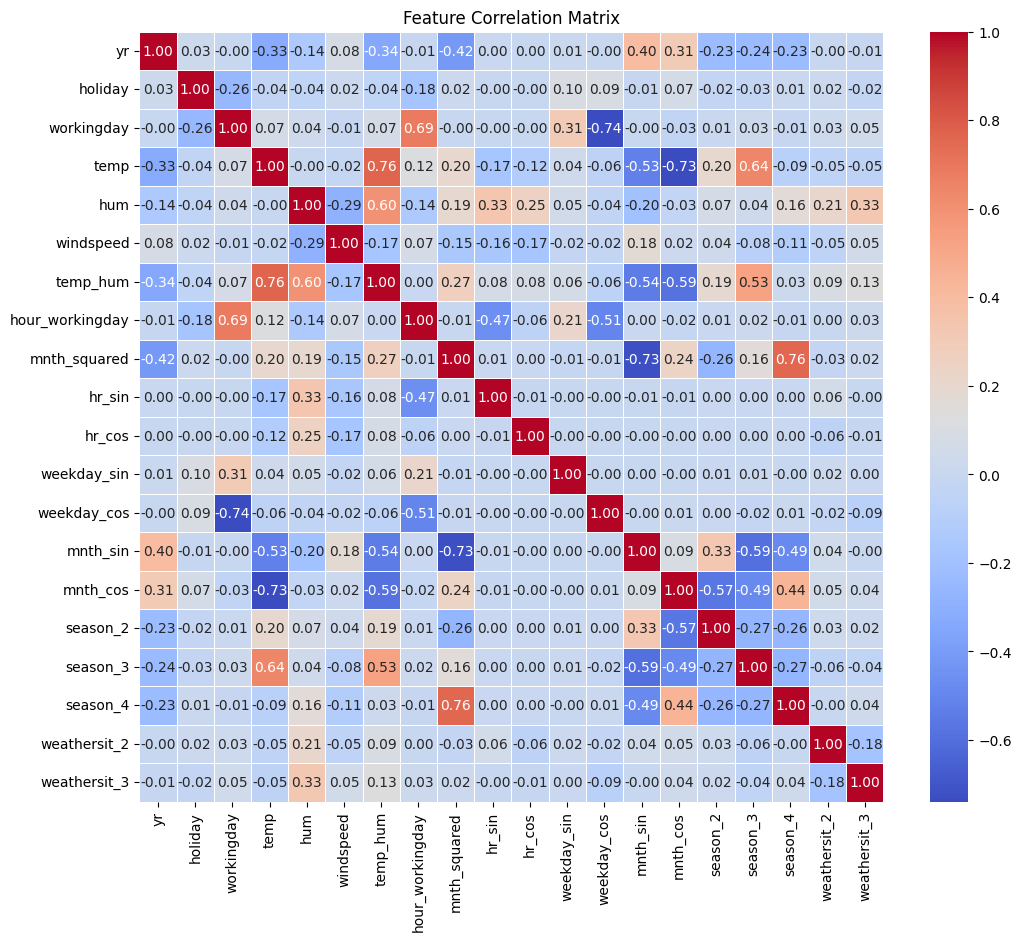

In [439]:
# Calculate the correlation matrix
correlation_matrix = X_train.corr()

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()


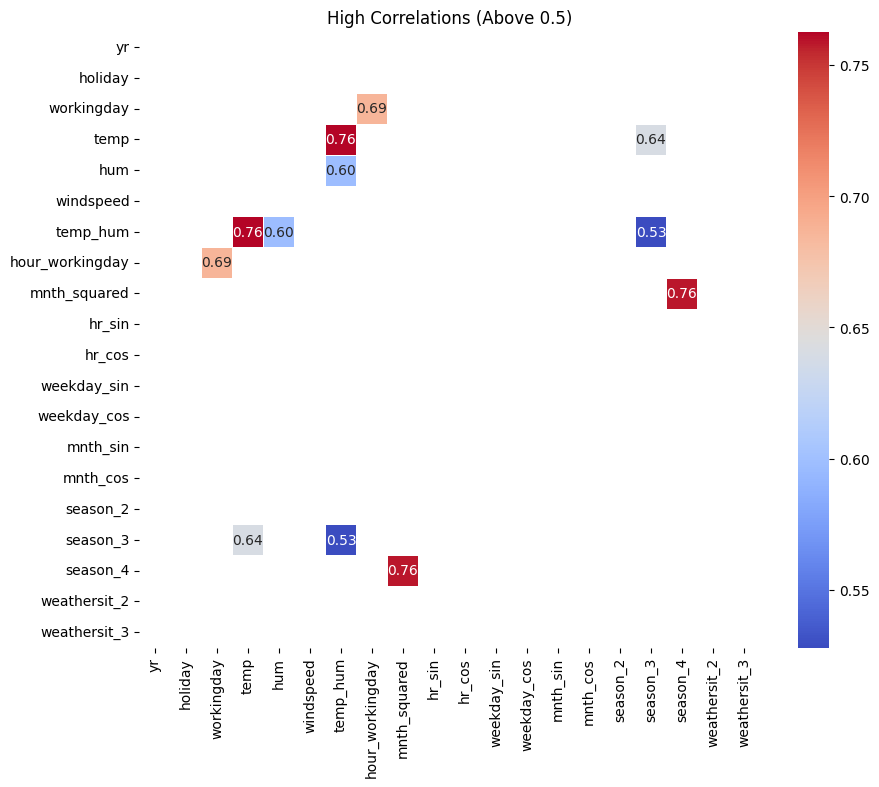

In [446]:
# Define correlation threshold
threshold = 0.5

# Create a mask for high correlations
high_corr = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1)]

# Display the high correlations
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'High Correlations (Above {threshold})')
plt.show()


In [444]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Fit Lasso model
lasso = Lasso(alpha=0.25)  # alpha controls regularization strength
lasso.fit(X_train, y_train)

# Check the coefficients
coefficients = pd.Series(lasso.coef_, index=X_train.columns)
print("Lasso Coefficients:")
print(coefficients[coefficients != 0])  # Features selected by Lasso


Lasso Coefficients:
yr                 72.127307
holiday            -2.294681
workingday        -11.075868
temp               47.018102
hum                 7.799404
windspeed          -2.603248
temp_hum          -25.571566
hour_workingday    14.069826
mnth_squared        8.523383
hr_sin            -60.985424
hr_cos            -70.441121
weekday_sin        -2.474669
weekday_cos         2.074198
mnth_sin          -12.647498
mnth_cos          -27.794645
season_2           14.553575
season_4           32.385690
weathersit_2       -7.988215
weathersit_3      -52.018694
dtype: float64


In [445]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# Random forest classifier
rf = RandomForestClassifier(n_jobs=-1, max_depth=5)

# Boruta feature selection
boruta = BorutaPy(rf, n_estimators='auto', random_state=42)
boruta.fit(X_train.values, y_train.values)

# Check selected features
selected_features = X_train.columns[boruta.support_]
print("Selected Features by Boruta:")
print(selected_features)


Selected Features by Boruta:
Index(['workingday', 'temp', 'hum', 'temp_hum', 'hour_workingday',
       'mnth_squared', 'hr_sin', 'hr_cos'],
      dtype='object')
